In [1]:
import keras.backend as K
K.set_image_data_format('channels_first')
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import numpy as np
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02)

Using TensorFlow backend.


In [2]:
def DCGAN_D(isize, nz, nc, ndf, n_extra_layers=0):
    assert isize%2==0
    _ = inputs = Input(shape=(nc, isize, isize))
    _ = Conv2D(filters=ndf, kernel_size=4, strides=2, use_bias=False,
                        padding = "same",
                        kernel_initializer = conv_init, 
                        name = 'initial.conv.{0}-{1}'.format(nc, ndf)             
                        ) (_)
    _ = LeakyReLU(alpha=0.2, name = 'initial.relu.{0}'.format(ndf))(_)
    csize, cndf = isize// 2, ndf
    while csize > 5:
        assert csize%2==0
        in_feat = cndf
        out_feat = cndf*2
        _ = Conv2D(filters=out_feat, kernel_size=4, strides=2, use_bias=False,
                        padding = "same",
                        kernel_initializer = conv_init,
                        name = 'pyramid.{0}-{1}.conv'.format(in_feat, out_feat)             
                        ) (_)
       # if 0: # toggle batchnormalization
           # _ = BatchNormalization(name = 'pyramid.{0}.batchnorm'.format(out_feat),                                   
                                  # momentum=0.9, axis=1, epsilon=1.01e-5,
                                  # gamma_initializer = gamma_init, 
                                  #)(_, training=1)        
        _ = LeakyReLU(alpha=0.2, name = 'pyramid.{0}.relu'.format(out_feat))(_)
        csize, cndf = (csize+1)//2, cndf*2
    _ = Conv2D(filters=1, kernel_size=csize, strides=1, use_bias=False,
                        kernel_initializer = conv_init,
                        name = 'final.{0}-{1}.conv'.format(cndf, 1)         
                        ) (_)
    outputs = Flatten()(_)
    return Model(inputs=inputs, outputs=outputs)

In [3]:
def DCGAN_G(isize, nz, nc, ngf, n_extra_layers=0):
    cngf= ngf//2
    tisize = isize
    while tisize > 5:
        cngf = cngf * 2
        assert tisize%2==0
        tisize = tisize // 2
    _ = inputs = Input(shape=(nz,))
    _ = Reshape((nz, 1,1))(_)
    _ = Conv2DTranspose(filters=cngf, kernel_size=tisize, strides=1, use_bias=False,
                           kernel_initializer = conv_init, 
                           name = 'initial.{0}-{1}.convt'.format(nz, cngf))(_)
    _ = BatchNormalization(gamma_initializer = gamma_init, momentum=0.9, axis=1, epsilon=1.01e-5,
                             name = 'initial.{0}.batchnorm'.format(cngf))(_, training=1)
    _ = Activation("relu", name = 'initial.{0}.relu'.format(cngf))(_)
    csize, cndf = tisize, cngf
    

    while csize < isize//2:
        in_feat = cngf
        out_feat = cngf//2
        _ = Conv2DTranspose(filters=out_feat, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init, padding="same",
                        name = 'pyramid.{0}-{1}.convt'.format(in_feat, out_feat)             
                        ) (_)
        _ = BatchNormalization(gamma_initializer = gamma_init,
                               momentum=0.9, axis=1, epsilon=1.01e-5,
                               name = 'pyramid.{0}.batchnorm'.format(out_feat))(_, training=1)
        
        _ = Activation("relu", name = 'pyramid.{0}.relu'.format(out_feat))(_)
        csize, cngf = csize*2, cngf//2
    _ = Conv2DTranspose(filters=nc, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init, padding="same",
                        name = 'final.{0}-{1}.convt'.format(cngf, nc)
                        )(_)
    outputs = Activation("tanh", name = 'final.{0}.tanh'.format(nc))(_)
    return Model(inputs=inputs, outputs=outputs)

In [4]:
nc = 3
nz = 100
ngf = 64
ndf = 64
n_extra_layers = 0
Diters = 5
λ = 10

imageSize = 64
batchSize = 16
lrD = 1e-4
lrG = 1e-4

In [5]:
netD = DCGAN_D(imageSize, nz, nc, ndf, n_extra_layers)
netD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 64, 64)         0         
_________________________________________________________________
initial.conv.3-64 (Conv2D)   (None, 64, 32, 32)        3072      
_________________________________________________________________
initial.relu.64 (LeakyReLU)  (None, 64, 32, 32)        0         
_________________________________________________________________
pyramid.64-128.conv (Conv2D) (None, 128, 16, 16)       131072    
_________________________________________________________________
pyramid.128.relu (LeakyReLU) (None, 128, 16, 16)       0         
_________________________________________________________________
pyramid.128-256.conv (Conv2D (None, 256, 8, 8)         524288    
_________________________________________________________________
pyramid.256.relu (LeakyReLU) (None, 256, 8, 8)         0         
__________

In [6]:
netG = DCGAN_G(imageSize, nz, nc, ngf, n_extra_layers)
netG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 1, 1)         0         
_________________________________________________________________
initial.100-512.convt (Conv2 (None, 512, 4, 4)         819200    
_________________________________________________________________
initial.512.batchnorm (Batch (None, 512, 4, 4)         2048      
_________________________________________________________________
initial.512.relu (Activation (None, 512, 4, 4)         0         
_________________________________________________________________
pyramid.512-256.convt (Conv2 (None, 256, 8, 8)         2097152   
_________________________________________________________________
pyramid.256.batchnorm (Batch (None, 256, 8, 8)         1024      
__________

In [7]:
from keras.optimizers import RMSprop, SGD, Adam
netD_real_input = Input(shape=(nc, imageSize, imageSize))
noisev = Input(shape=(nz,))
netD_fake_input = netG(noisev)
ϵ_input = K.placeholder(shape=(None, nc,imageSize,imageSize))
netD_mixed_input = Input(shape=(nc, imageSize, imageSize),  tensor=netD_real_input + ϵ_input)


loss_real = K.mean(netD(netD_real_input))
loss_fake = K.mean(netD(netD_fake_input))

grad_mixed = K.gradients(netD(netD_mixed_input), [netD_mixed_input])[0]
norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
grad_penalty = K.mean(K.square(norm_grad_mixed -1))

loss = loss_fake - loss_real + λ * grad_penalty


training_updates = Adam(lr=lrD,beta_1=0.5).get_updates(netD.trainable_weights,[],loss)
netD_train = K.function([netD_real_input, noisev, ϵ_input],
                        [loss_real, loss_fake],    
                        training_updates)

In [8]:
loss = -loss_fake 
training_updates = Adam(lr=lrG,beta_1=0.5).get_updates(netG.trainable_weights,[], loss)
netG_train = K.function([noisev], [loss], training_updates)

In [9]:
X_train, X_test = np.load('./Vtuber.npy') 

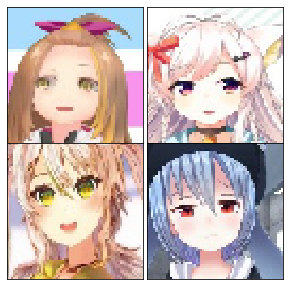

In [10]:
idx = np.random.randint(0,X_train.shape[0],size = 4)
fig,axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(5,5),)
for ii,ax in zip(idx,axes.flatten()):
    ax.imshow(X_train[ii,:,:,:],aspect = 'equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0,hspace=0)    

In [11]:
X_train = np.float32(X_train)
X_train = X_train.reshape(-1,3,64,64)/255
X_train = X_train*2 -1
X_train.shape

(16143, 3, 64, 64)

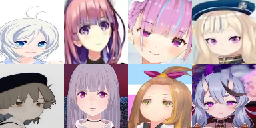

In [12]:
from PIL import Image
from IPython.display import display
def showX(X, rows=2):
    assert X.shape[0]%rows == 0
    int_X = ( (X - X.min()) * 255 / (X.max() - X.min())).astype(np.uint8)
    # N*3072 -> N*3*32*32 -> 32 * 32N * 3
    #int_X = np.moveaxis(int_X.reshape(-1,3,64,64), 1, 3)
    int_X = int_X.reshape(rows, -1, 64, 64,3).swapaxes(1,2).reshape(rows*64,-1, 3)
    display(Image.fromarray(int_X))
# 訓練資料， X 的前 20 筆
showX(X_train[:8])


In [13]:
fixed_noise = np.random.normal(size=(batchSize, nz)).astype('float32')

[0/1000][100/1008][0] Loss_D: 189.957947 Loss_G: 0.000000 Loss_D_real: 166.831284 Loss_D_fake -23.126659 7.669061899185181


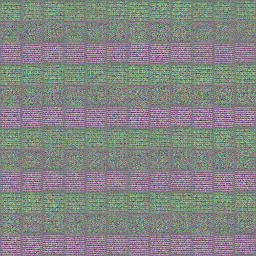

In [ ]:
import time
t0 = time.time()
niter = 1000
gen_iterations = 0
errG = 0
targetD = np.float32([2]*batchSize+[-2]*batchSize)[:, None]
targetG = np.ones(batchSize, dtype=np.float32)[:, None]
for epoch in range(niter):
    i = 0
    #  每個 epoch 洗牌一下
    np.random.shuffle(X_train)
    batches = X_train.shape[0]//batchSize
    while i < batches:
        if gen_iterations < 25 or gen_iterations % 500 == 0:
            _Diters = 100
        else:
            _Diters = Diters
        j = 0
        while j < _Diters and i < batches:
            j+=1
            real_data = X_train[i*batchSize:(i+1)*batchSize]
            i+=1
            noise = np.random.normal(size=(batchSize, nz))        
            ϵ = real_data.std() * np.random.uniform(-0.5,0.5, size=real_data.shape) 
            ϵ *= np.random.uniform(size=(batchSize, 1,1,1))
            errD_real, errD_fake  = netD_train([real_data, noise, ϵ]) 
            errD = errD_real - errD_fake
       
        if gen_iterations%500==0:
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
            % (epoch, niter, i, batches, gen_iterations,errD, errG, errD_real, errD_fake), time.time()-t0)
            fake = netG.predict(fixed_noise)
            showX(fake,4)
            netG.save("DRAGAN_model/dragan-{}-epoch.h5".format(epoch))
            
        
        noise = np.random.normal(size=(batchSize, nz))        
        errG, = netG_train([noise])
        gen_iterations+=1